In [1]:
%load_ext autoreload
%autoreload 2

# add Code folder, if the package is not installed.
import sys
sys.path.append('../src')

In [2]:
import sys
sys.base_exec_prefix

'/usr'

In [3]:
# import main class and plotting function
from qdarts.plotting import plot_polytopes

# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Construction

First we need to define the layout and capacitance parameters of the device.

We start by defining the dot and plunger layout of the device. 
Not all of this is relevant for the simulator, but it will help us greatly
in keeping track of what the indices mean.
our device is a device with 6 dots, with three inner dots and three sensor dots.
We assume that the device is in a triangle formation, where the three inner dots form
an equilateral triangle and behind each dot is another sensor dot. Additionally,
we will have three barrier gates, between the three inner dots that modify the tunnel-coupling
between the inner dots. 



In [4]:
# Define the system

N_dots = 6 #number of dots
N_gates = 9 # 6 dot plungers + 3 barrier gates
inner_dots = [0,1,2]
sensor_dots = [3,4,5]

dot_plungers = [0,1,2]
barrier_plungers = [3,4,5]
sensor_plungers = [6,7,8]


Next, we setup the capacitance matrices. These depend on the target device layout. For a device such as this, the number of parameters grows already very large. Feel free to skip the definition of the parameters.

In [5]:

#All capacitances are given in atto Farrad

#let us first define the inter-dot dot capacitance matrix. We will first set up
#only one pair and then we will symmetrize the matrix in the end.
C_DD=20* np.eye((N_dots))/2 #The self-capacitance of each dot, NOTE: factor of 2 due to symmetrization

#capacitances inner dots
C_DD[inner_dots[0],inner_dots[1]] = 10
C_DD[inner_dots[1],inner_dots[2]] = 10
C_DD[inner_dots[2],inner_dots[0]] = 10

#setup the sensor-dot <->inner dot capacitances.
for i in range(3):
    for j in range(3):
        if i == j:
            C_DD[inner_dots[i], sensor_dots[j]] = 4 #sensor dot closest to the inner dot.
        else:
            C_DD[inner_dots[i], sensor_dots[j]] = 1.0 #sensor dot further away

#symmetrize
C_DD = C_DD + C_DD.T

#dot-gate capacitances.
C_DG = np.zeros((N_dots, N_gates))
#dot to plunger-gate capacitances
for i in range(3):
    C_DG[inner_dots[i],dot_plungers[i]] = 11 #ith dot plunger to the ith dot
    C_DG[sensor_dots[i],sensor_plungers[i]] = 11 #ith sensor plunger to the ith sensor
    C_DG[sensor_dots[i],dot_plungers[i]] = 1.5 #ith dot plunger to the ith sensor (cross-talk)
    
#further cross-talk inner dot plungers -> sensor for the plungers that are further away
C_DG[sensor_dots[0],dot_plungers[1]] = 0.5
C_DG[sensor_dots[0],dot_plungers[2]] = 0.5
C_DG[sensor_dots[1],dot_plungers[0]] = 0.5
C_DG[sensor_dots[1],dot_plungers[2]] = 0.5
C_DG[sensor_dots[2],dot_plungers[0]] = 0.5
C_DG[sensor_dots[2],dot_plungers[1]] = 0.5

#cross-talk inner dots <-> dot plungers for the plungers that are further away
C_DG[inner_dots[0],dot_plungers[1]] = 1.5
C_DG[inner_dots[0],dot_plungers[2]] = 1.5
C_DG[inner_dots[1],dot_plungers[0]] = 1.5
C_DG[inner_dots[1],dot_plungers[2]] = 1.5
C_DG[inner_dots[2],dot_plungers[0]] = 1.5
C_DG[inner_dots[2],dot_plungers[1]] = 1.5

#cross-talk barrier gates <-> inner dots
C_DG[inner_dots[0],barrier_plungers[0]] = 1.2
C_DG[inner_dots[0],barrier_plungers[1]] = 0.8
C_DG[inner_dots[0],barrier_plungers[2]] = 1.2

C_DG[inner_dots[1],barrier_plungers[0]] = 1.2
C_DG[inner_dots[1],barrier_plungers[1]] = 1.2
C_DG[inner_dots[1],barrier_plungers[2]] = 0.8

C_DG[inner_dots[2],barrier_plungers[0]] = 0.8
C_DG[inner_dots[2],barrier_plungers[1]] = 1.2
C_DG[inner_dots[2],barrier_plungers[2]] = 1.2

#cross talk barrier gates -> sensor dots
C_DG[inner_dots[0],barrier_plungers[0]] = 0.5
C_DG[inner_dots[0],barrier_plungers[1]] = 0.1
C_DG[inner_dots[0],barrier_plungers[2]] = 0.5

C_DG[inner_dots[1],barrier_plungers[0]] = 0.5
C_DG[inner_dots[1],barrier_plungers[1]] = 0.5
C_DG[inner_dots[1],barrier_plungers[2]] = 0.1

C_DG[inner_dots[2],barrier_plungers[0]] = 0.1
C_DG[inner_dots[2],barrier_plungers[1]] = 0.5
C_DG[inner_dots[2],barrier_plungers[2]] = 0.5

To define the model, we need to introduce lower bound values for each capacitances in order to prevent unbounded polytopes.
We will pick as capcitance model a slight generalization of the constant interaction model that is defined using the capacitances above 
and which additionally allows to include deviations from the constant interaction model using a parameter k for each dot. These deviations model a slight change of capacitance values as the number of electrons increases. Larger values lead to smaller effects. Set k to None to disable this feature.

Using the capacitance model, it is straight forward to define the capacitive simulation.

In [6]:
from qdarts.capacitance_model import CapacitanceModel
from qdarts.simulator import CapacitiveDeviceSimulator

#minimum voltages for each plunger gate. 
bounds_limits = -1.0*np.ones(N_gates)

#deviation from the constant interaction model. Set to None to have no deviation
ks = 4*np.ones(N_dots)

capacitance_model = CapacitanceModel(C_DG, C_DD, bounds_limits, ks=ks)
capacitive_sim = CapacitiveDeviceSimulator(capacitance_model)

/home/ulfi/QDarts/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Rastering CSD: 100%|███████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16074.52it/s]


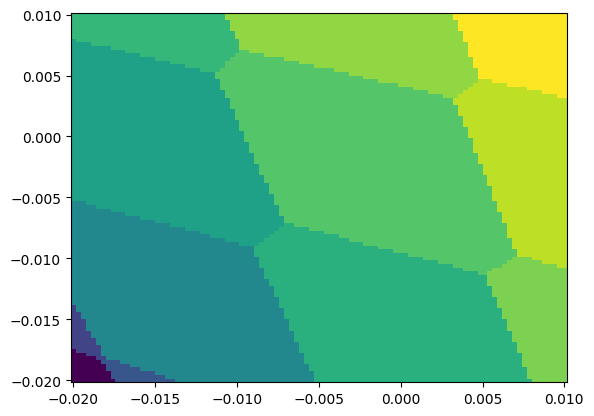

In [7]:
target_state = [1,1,1,5,5,5]
m = capacitive_sim.boundaries(target_state).point_inside

P = np.zeros((N_gates,2))
P[0,0] = 1
P[2,1] = 1

from qdarts.plotting import get_CSD_data

minV = np.array([-0.02,-0.02])
maxV = np.array([ 0.01, 0.01])
resolution = 100

sliced_csim, CSD_data, states =  get_CSD_data(capacitive_sim, P,m,  minV, maxV, resolution, target_state)

xs = np.linspace(minV[0],maxV[0],resolution)
ys = np.linspace(minV[1],maxV[1],resolution)
plt.pcolormesh(xs,ys,CSD_data)



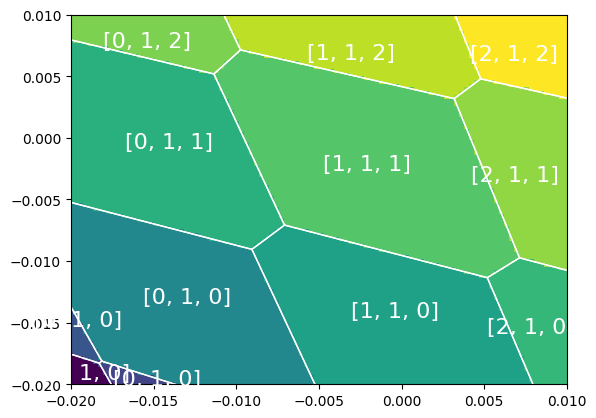

In [8]:
from qdarts.plotting import get_polytopes, plot_polytopes

plt.pcolormesh(xs,ys,CSD_data.T)
polytopes = get_polytopes(states, sliced_csim, minV, maxV)
plt.xlim(minV[0],maxV[0])
plt.ylim(minV[1],maxV[1])
plot_polytopes(plt.gca(),polytopes, skip_dots=[3,4,5], fontsize=16)



In [9]:
# Definition of the tunnel couplings in eV 
# NOTE: we use the convention that tc is the energy gap at avoided crossing H = tc/2 sx
tunnel_couplings = np.zeros((N_dots,N_dots))
tunnel_couplings[0,1] = 30*1e-6
tunnel_couplings[0,2] = 30*1e-6
tunnel_couplings[1,2] = 30*1e-6
tunnel_couplings = tunnel_couplings+ tunnel_couplings.T

temperature = 0.1 # 100mK

from qdarts.tunneling_simulator import NoisySensorDot, ApproximateTunnelingSimulator



sensor_model = NoisySensorDot(sensor_dots) #a model of the sensor dots that just needs which dot has which index
sensor_model.config_peak(g_max = 1.0, peak_width_multiplier = 20) #make the sensor peak broader
tunneling_sim = ApproximateTunnelingSimulator(capacitive_sim, #the underlying polytope simulation
                                             tunnel_couplings,  #constant tunnel couplings
                                             temperature, #electron temperature, should be <=200mK
                                             sensor_model) #our sensor model simulation

capacitive_sim.set_maximum_polytope_slack(5/tunneling_sim.beta) #adding slack to keep more states that are likely to affect the hamiltonian
tunneling_sim.num_additional_neighbours[sensor_dots] = 2 #adding additional states for the sensor dots


In [10]:
capacitive_sim.boundaries(target_state).point_inside

array([ 0.0860137 ,  0.0860137 ,  0.0860137 , -0.92543255, -0.92543255,
       -0.92543255,  0.03458833,  0.03458833,  0.03458833])

In [11]:
state=tunneling_sim.poly_sim.find_state_of_voltage(m, [0,0,0,2,2,2])
sensor_values = tunneling_sim.sensor_scan_2D(P, m, minV, maxV, resolution, state,cache=False)

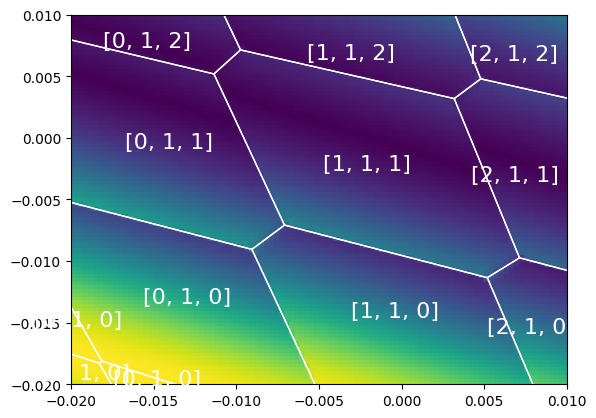

In [12]:
plt.pcolormesh(xs,ys,sensor_values[:,:,2].T)
polytopes = get_polytopes(states, sliced_csim, minV, maxV)
plt.xlim(minV[0],maxV[0])
plt.ylim(minV[1],maxV[1])
plot_polytopes(plt.gca(),polytopes, skip_dots=[3,4,5], fontsize=16)

Rastering CSD: 100%|███████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 67167.54it/s]


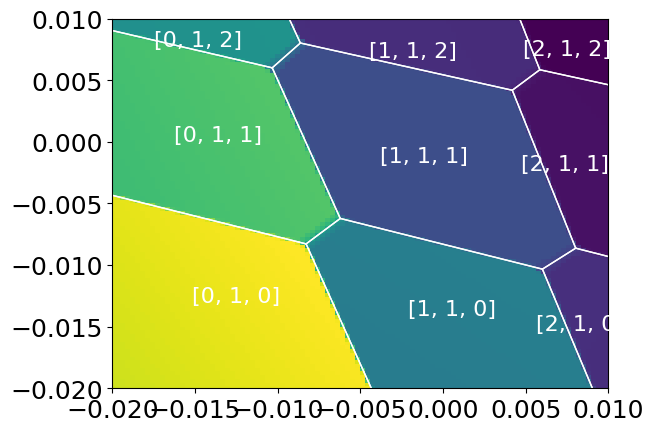

In [78]:
from qdarts.experiment import compensate_simulator_sensors

compensated_tsim, m_comp = compensate_simulator_sensors(
    tunneling_sim, #the simulator object to compensate
    target_state=[1,1,1,5,5,5], #the electron configuration around which to compensate
    compensation_gates= [6,7,8], #the ids of the sensor gate plungers.
    sensor_ids = [3,4,5],#the ids of the sensor dots.
    sensor_detunings = np.array([-0.0005,-0.0005,-0.0005]) #shift of the sensor dot plungers
)
sensor_values = compensated_tsim.sensor_scan_2D(P, m_comp, minV, maxV, resolution, target_state)
sliced_tsim, CSD_data, states =  get_CSD_data(compensated_tsim.poly_sim, P,m_comp,  minV, maxV, resolution, target_state)
polytopes = get_polytopes(states, sliced_tsim, minV, maxV)

plt.pcolormesh(xs,ys,sensor_values[:,:,2])
plt.xlim(minV[0],maxV[0])
plt.ylim(minV[1],maxV[1])
plot_polytopes(plt.gca(),polytopes, skip_dots=[3,4,5], fontsize=16)

In [79]:
compensated_tsim, m_comp = compensate_simulator_sensors(
    tunneling_sim, #the simulator object to compensate
    target_state=[1,1,1,5,5,5], #the electron configuration around which to compensate
    compensation_gates= [6,7,8], #the ids of the sensor gate plungers.
    sensor_ids = [3,4,5],#the ids of the sensor dots.
    sensor_detunings = np.array([-0.0005,-0.0005,-0.0005]) #shift of the sensor dot plungers
)
compensated_tsim.poly_sim.find_state_of_voltage(m_comp,target_state)

[1, 1, 1, 5, 5, 5]